<a href="https://colab.research.google.com/github/Frans-Grau/P5-Forecasting/blob/main/Forecast/Forecast_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Imports 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as plt
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px

In [2]:
### Load the Datasets
df2016 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2016.csv')
df2017 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2017.csv')
df2018 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2018.csv')

### Quick preprocessing
df_all = pd.concat([df2016,df2017,df2018], ignore_index = True, axis = 0)
df_all.drop(['Unnamed: 0','CANCELLED','DIVERTED'], axis=1, inplace= True)
df_all.dropna(inplace=True)
df_all['FL_DATE'] = pd.to_datetime(df_all['FL_DATE'])

### New column OP-Carrier code to full Airline Name
df_all['AIRLINE'] = df_all['OP_CARRIER'].apply(lambda x: 'Delta Airlines' if x == 'DL' else 'Southwest Airlines' if x=='WN' else 'American Airlines' if x=='AA' 
else 'JetBlue Airways' if x=='B6' else 'SkyWest Airlines' if x=='OO' else 'Atlantic Southeast Airlines' if x == 'EV' else 'United Airlines' if x == 'UA' 
else 'Pinnacle Airlines' if x == '9E' else 'Spirit Airlines' if x== 'NK' else 'Alaska Airlines' if x == 'AS' else 'Virgin America' if x == 'VX' else 'Frontier' if x =='F9' 
else 'Republic Airlines' if x == 'YX'else 'Hawaiian Airlines' if x == 'HA' else 'Envoy Air' if x == 'MQ' else 'Air Shuttle' if x == 'YV' else 'Allegiant Air' if x=='G4' 
else 'Comair')

df_all.head()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,AIR_TIME,DISTANCE,AIRLINE
0,2016-01-01,DL,ATL,GRR,2125,2130.0,5.0,2321,2319.0,92.0,640.0,Delta Airlines
1,2016-01-01,DL,LAX,ATL,2255,2256.0,1.0,600,547.0,207.0,1947.0,Delta Airlines
2,2016-01-01,DL,ATL,BNA,1233,1356.0,83.0,1239,1402.0,38.0,214.0,Delta Airlines
3,2016-01-01,DL,ATL,JAX,945,946.0,1.0,1050,1053.0,45.0,270.0,Delta Airlines
4,2016-01-01,DL,ATL,OKC,2110,2107.0,-3.0,2236,2224.0,116.0,761.0,Delta Airlines


Forecast on all Data - No airport Split

In [ ]:
### Group the delay minutes by date
df_delay = df_all.groupby('FL_DATE')['DEP_DELAY'].mean().reset_index()
df_delay = df_delay.sort_values('FL_DATE')
df_delay['Month'] = pd.DatetimeIndex(df_delay['FL_DATE']).month
df_delay = df_delay.sort_values('FL_DATE').set_index('FL_DATE')
df_delay.drop('Month', axis=1, inplace = True)

#Create the train set
train_set = df_delay.head(int(df_delay.shape[0]-273))
print('The minimum date we have is', train_set.index.min(), 'and the maximum date is ',  train_set.index.max())

#Create the test set
test_set = df_delay[~df_delay.index.isin(train_set.index)]
print('The minimum date we have is', test_set.index.min(), 'and the maximum date is ',  test_set.index.max())

### Grab all the predictions
allx = list(range(1,274))   
allx.reverse()


def forecastx(x):
    test_set = df_delay.tail(x)
    train_set = df_delay.head(int(df_delay.shape[0]-test_set.shape[0]))
    arima_model = ARIMA(train_set['DEP_DELAY'], order=(2,0,1))
    arima_model_fit = arima_model.fit()
    forecast  = arima_model_fit.forecast()
    return forecast
   

dep_delay_forecast = list(map(forecastx, allx))
dep_delay_forecast

#exp smoothing
allx = list(range(1, 274))
allx.reverse()

def expsm_forecastx(t):
    test_set = df_delay.tail(t)
    train_set = df_delay.head(int(df_delay.shape[0]-test_set.shape[0]))
    exp_smoothing = ExponentialSmoothing(train_set['DEP_DELAY'])
    exp_smoothing_fit = exp_smoothing.fit(optimized = True)
    exp_smoothing_fit.forecast()
    forecast =  exp_smoothing_fit.forecast()
    return forecast.iloc[0]

dep_delay_forecast_expsm = list(map(expsm_forecastx, allx))

### Pass the resulting list to a DF, and then merging to test set to check the diff between actual and predicted
df1= pd.concat(dep_delay_forecast).to_frame()
evaluation = test_set
evaluation['Forecast_Arima'] = df1.values
evaluation
evaluation['Forecast_Expsm'] = list(dep_delay_forecast_expsm)
evaluation.rename(columns={'DEP_DELAY': 'Test_Set'},
          inplace=True, errors='raise')


In [4]:
### ERRORS MEASUREMENTS
expected = evaluation['DEP_DELAY']
predicted = evaluation['Forecast']

## Mean Forecast Error
forecast_errors = [expected[i]-predicted[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
print('Mean Forecast Error - Bias: %f' % bias)

## Mean Absolute Error
mae = mean_absolute_error(expected, predicted)
print('Mean absolute error : %f' % mae)

## Mean Squared Error if = 0 Means NO ERROR
mse = mean_squared_error(expected, predicted)
print('Mean Squared Error: %f' % mse)

## Root Mean Squared Error if = 0 Means NO ERROR
rmse = sqrt(mse)
print('Root Mean Squared Error: %f' % rmse)

Mean Forecast Error - Bias: -0.219723
Mean absolute error : 5.190589
Mean Squared Error: 59.934896
Root Mean Squared Error: 7.741763


In [12]:
#plot both
fig = px.line(evaluation, x = evaluation.index, y = ['Test_Set', 'Forecast', 'Forecast_Expsm']) #, color_discrete_sequence=["#ff97ff"])
fig.show()

In [ ]:
###Forecast 
new_dates = pd.date_range(start="2019-01-01",end="2019-03-31")
df_new_dates = pd.DataFrame(new_dates)
df_new_dates.rename(columns = {0 : 'FL_DATE'}, inplace = True)
df_delay.reset_index(inplace = True)
df_new = pd.concat([df_delay, df_new_dates], axis = 0)
df_new.set_index('FL_DATE', inplace = True)

#function to predict new values
allx = list(range(1, 91))
allx.reverse()
def forecastx(x):
    test_set = df_new.tail(x)
    train_set = df_new.head(int(df_new.shape[0]-test_set.shape[0]))
    arima_model = ARIMA(df_new['DEP_DELAY'], order=(2,0,1), freq = 'D')
    arima_model_fit = arima_model.fit()
    forecast =  arima_model_fit.forecast()
    return forecast
dep_delay_forecast_new = list(map(forecastx, allx))
dep_delay_forecast_new

df_result_new = pd.DataFrame(dep_delay_forecast_new)
df_result_new = pd.melt(df_result_new).dropna().rename(columns = {'variable' : 'FL_DATE', 'value' : 'DEP_DELAY'})
df_final = pd.concat([df_delay,df_result_new ], axis=0)
df_final = df_final.set_index('FL_DATE')

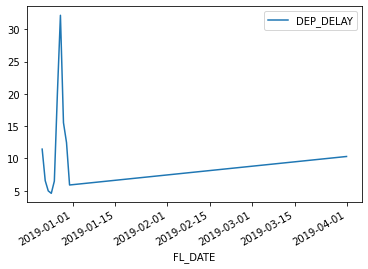

In [14]:
df_final.iloc[-100 : -80].plot()

**Forecast For Each Airport**


In [ ]:
### Create DF for each airport
## LAX - Los Angeles
df_LAX = df_all[df_all['ORIGIN'] == 'LAX']
delay_LAX = df_LAX.groupby('FL_DATE')['DEP_DELAY'].mean().reset_index()
delay_LAX = delay_LAX.sort_values('FL_DATE')
delay_LAX = delay_LAX.sort_values('FL_DATE').set_index('FL_DATE')

## JFK - NYC
df_JFK = df_all[df_all['ORIGIN'] == 'JFK']
delay_JFK = df_JFK.groupby('FL_DATE')['DEP_DELAY'].mean().reset_index()
delay_JFK = delay_JFK.sort_values('FL_DATE')
delay_JFK = delay_JFK.sort_values('FL_DATE').set_index('FL_DATE')

## ATL - Atlanta
df_ATL = df_all[df_all['ORIGIN'] == 'ATL']
delay_ATL = df_ATL.groupby('FL_DATE')['DEP_DELAY'].mean().reset_index()
delay_ATL = delay_ATL.sort_values('FL_DATE')
delay_ATL = delay_ATL.sort_values('FL_DATE').set_index('FL_DATE')

LAX - FORECAST

In [ ]:
### ARIMA 

### Group the delay minutes by date
df_LAX = df_all[df_all['ORIGIN'] == 'LAX']
delay_LAX = df_LAX.groupby('FL_DATE')['DEP_DELAY'].mean().reset_index()
delay_LAX = delay_LAX.sort_values('FL_DATE')
delay_LAX = delay_LAX.sort_values('FL_DATE').set_index('FL_DATE')

# Create the train set
train_set_LAX = delay_LAX.head(int(delay_LAX.shape[0]-273))
print('The minimum date we have is', train_set_LAX.index.min(), 'and the maximum date is ',  train_set_LAX.index.max())

#Create the test set
test_set_LAX = delay_LAX[~delay_LAX.index.isin(train_set_LAX.index)]
print('The minimum date we have is', test_set_LAX.index.min(), 'and the maximum date is ',  test_set_LAX.index.max())



### Grab all the predictions
allx = list(range(1,274))   
allx.reverse()


def forecastx(x):
    test_set_LAX = delay_LAX.tail(x)
    train_set_LAX = delay_LAX.head(int(delay_LAX.shape[0]-test_set_LAX.shape[0]))
    arima_model = ARIMA(train_set_LAX['DEP_DELAY'], order=(2,0,1))
    arima_model_fit = arima_model.fit()
    forecast  = arima_model_fit.forecast()
    return forecast
   

dep_delay_forecast_LAX = list(map(forecastx, allx))
dep_delay_forecast_LAX

#exp smoothing
allx = list(range(1, 274))
allx.reverse()

def expsm_forecastx(t):
    test_set_LAX = delay_LAX.tail(t)
    train_set_LAX = delay_LAX.head(int(delay_LAX.shape[0]-test_set_LAX.shape[0]))
    exp_smoothing = ExponentialSmoothing(train_set_LAX['DEP_DELAY'])
    exp_smoothing_fit = exp_smoothing.fit(optimized = True)
    exp_smoothing_fit.forecast()
    forecast =  exp_smoothing_fit.forecast()
    return forecast.iloc[0]

dep_delay_forecast_expsm_LAX = list(map(expsm_forecastx, allx))

### Pass the resulting list to a DF, and then merging to test set to check the diff between actual and predicted
df1_LAX= pd.concat(dep_delay_forecast_LAX).to_frame()
evaluation_LAX = test_set_LAX
evaluation_LAX['Forecast_Arima'] = df1_LAX.values
evaluation_LAX
evaluation_LAX['Forecast_Expsm'] = list(dep_delay_forecast_expsm_LAX)
evaluation_LAX.rename(columns={'DEP_DELAY': 'Test_Set_LAX'},
          inplace=True, errors='raise')

###Forecast 
new_dates = pd.date_range(start="2019-01-01",end="2019-03-31")
df_new_dates = pd.DataFrame(new_dates)
df_new_dates.rename(columns = {0 : 'FL_DATE'}, inplace = True)
delay_LAX.reset_index(inplace = True)
df_new = pd.concat([delay_LAX, df_new_dates], axis = 0)
df_new.set_index('FL_DATE', inplace = True)

#function to predict new values
allF = list(range(1, 91))
allF.reverse()
def forecastx(x):
    test_set_LAX = df_new.tail(x)
    train_set_LAX = df_new.head(int(df_new.shape[0]-test_set_LAX.shape[0]))
    arima_model = ARIMA(df_new['DEP_DELAY'], order=(2,0,1), freq = 'D')
    arima_model_fit = arima_model.fit()
    forecast =  arima_model_fit.forecast()
    return forecast
dep_delay_forecast_new_LAX = list(map(forecastx, allF))
dep_delay_forecast_new_LAX

df_result_new_LAX = pd.DataFrame(dep_delay_forecast_new_LAX)
df_result_new_LAX = pd.melt(df_result_new_LAX).dropna().rename(columns = {'variable' : 'FL_DATE', 'value' : 'DEP_DELAY'})
df_final_LAX = pd.concat([delay_LAX,df_result_new_LAX ], axis=0)
df_final_LAX = df_final_LAX.set_index('FL_DATE')

In [19]:
#plot both
fig = px.line(evaluation_LAX, x = evaluation_LAX.index, y = ['Test_Set_LAX', 'Forecast_Arima', 'Forecast_Expsm'])
fig.show()

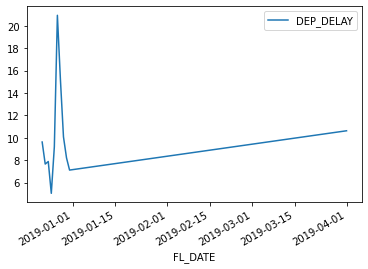

In [20]:
df_final_LAX.iloc[-100 : -80].plot()

**JFK Forecast**

In [ ]:
## JFK - NYC
df_JFK = df_all[df_all['ORIGIN'] == 'JFK']
delay_JFK = df_JFK.groupby('FL_DATE')['DEP_DELAY'].mean().reset_index()
delay_JFK = delay_JFK.sort_values('FL_DATE')
delay_JFK = delay_JFK.sort_values('FL_DATE').set_index('FL_DATE')

# Create the train set
train_set_JFK = delay_JFK.head(int(delay_JFK.shape[0]-272))
print('The minimum date we have is', train_set_JFK.index.min(), 'and the maximum date is ',  train_set_JFK.index.max())

#Create the test set
test_set_JFK = delay_JFK[~delay_JFK.index.isin(train_set_JFK.index)]
print('The minimum date we have is', test_set_JFK.index.min(), 'and the maximum date is ',  test_set_JFK.index.max())



### Grab all the predictions
allx = list(range(1,273))   
allx.reverse()


def forecastx(x):
    test_set_JFK = delay_JFK.tail(x)
    train_set_JFK = delay_JFK.head(int(delay_JFK.shape[0]-test_set_JFK.shape[0]))
    arima_model = ARIMA(train_set_JFK['DEP_DELAY'], order=(2,0,1))
    arima_model_fit = arima_model.fit()
    forecast  = arima_model_fit.forecast()
    return forecast
   

dep_delay_forecast_JFK = list(map(forecastx, allx))
dep_delay_forecast_JFK

#exp smoothing
allx = list(range(1, 273))
allx.reverse()

def expsm_forecastx(t):
    test_set_JFK = delay_JFK.tail(t)
    train_set_JFK = delay_JFK.head(int(delay_JFK.shape[0]-test_set_JFK.shape[0]))
    exp_smoothing = ExponentialSmoothing(train_set_JFK['DEP_DELAY'])
    exp_smoothing_fit = exp_smoothing.fit(optimized = True)
    exp_smoothing_fit.forecast()
    forecast =  exp_smoothing_fit.forecast()
    return forecast.iloc[0]

dep_delay_forecast_expsm_JFK = list(map(expsm_forecastx, allx))

### Pass the resulting list to a DF, and then merging to test set to check the diff between actual and predicted
df1_JFK= pd.concat(dep_delay_forecast_JFK).to_frame()
evaluation_JFK = test_set_JFK
evaluation_JFK['Forecast_Arima'] = df1_JFK.values
evaluation_JFK
evaluation_JFK['Forecast_Expsm'] = list(dep_delay_forecast_expsm_JFK)
evaluation_JFK.rename(columns={'DEP_DELAY': 'Test_Set_JFK'},
          inplace=True, errors='raise')

###Forecast 
new_dates = pd.date_range(start="2019-01-01",end="2019-03-31")
df_new_dates = pd.DataFrame(new_dates)
df_new_dates.rename(columns = {0 : 'FL_DATE'}, inplace = True)
delay_JFK.reset_index(inplace = True)
df_new = pd.concat([delay_JFK, df_new_dates], axis = 0)
df_new.set_index('FL_DATE', inplace = True)

#function to predict new values
allF = list(range(1, 91))
allF.reverse()
def forecastx(x):
    test_set_JFK = df_new.tail(x)
    train_set_JFK = df_new.head(int(df_new.shape[0]-test_set_JFK.shape[0]))
    arima_model = ARIMA(df_new['DEP_DELAY'], order=(2,0,1), freq='D')
    arima_model_fit = arima_model.fit()
    forecast =  arima_model_fit.forecast()
    return forecast
dep_delay_forecast_new_JFK = list(map(forecastx, allF))
dep_delay_forecast_new_JFK

df_result_new_JFK = pd.DataFrame(dep_delay_forecast_new_JFK)
df_result_new_JFK = pd.melt(df_result_new_JFK).dropna().rename(columns = {'variable' : 'FL_DATE', 'value' : 'DEP_DELAY'})
df_final_JFK = pd.concat([delay_LAX,df_result_new_JFK ], axis=0)
df_final_JFK = df_final_JFK.set_index('FL_DATE')

In [25]:
#plot both
fig = px.line(evaluation_JFK, x = evaluation_JFK.index, y = ['Test_Set_JFK', 'Forecast_Arima', 'Forecast_Expsm'])
fig.show()

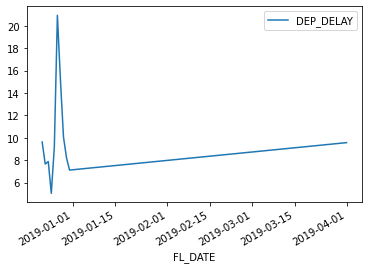

In [43]:
df_final_JFK.iloc[ -100:-80].plot()

**ATL Forecast**

In [ ]:
### ARIMA 

## ATL - Atlanta
df_ATL = df_all[df_all['ORIGIN'] == 'ATL']
delay_ATL = df_ATL.groupby('FL_DATE')['DEP_DELAY'].mean().reset_index()
delay_ATL = delay_ATL.sort_values('FL_DATE')
delay_ATL = delay_ATL.sort_values('FL_DATE').set_index('FL_DATE')

# Create the train set
train_set_ATL = delay_ATL.head(int(delay_ATL.shape[0]-273))
print('The minimum date we have is', train_set_ATL.index.min(), 'and the maximum date is ',  train_set_ATL.index.max())

#Create the test set
test_set_ATL = delay_ATL[~delay_ATL.index.isin(train_set_ATL.index)]
print('The minimum date we have is', test_set_ATL.index.min(), 'and the maximum date is ',  test_set_ATL.index.max())



### Grab all the predictions
allx = list(range(1,274))   
allx.reverse()


def forecastx(x):
    test_set_ATL = delay_ATL.tail(x)
    train_set_ATL = delay_ATL.head(int(delay_ATL.shape[0]-test_set_ATL.shape[0]))
    arima_model = ARIMA(train_set_ATL['DEP_DELAY'], order=(2,0,1))
    arima_model_fit = arima_model.fit()
    forecast  = arima_model_fit.forecast()
    return forecast
   

dep_delay_forecast_ATL = list(map(forecastx, allx))
dep_delay_forecast_ATL

#exp smoothing
allx = list(range(1, 274))
allx.reverse()

def expsm_forecastx(t):
    test_set_ATL = delay_ATL.tail(t)
    train_set_ATL = delay_ATL.head(int(delay_ATL.shape[0]-test_set_ATL.shape[0]))
    exp_smoothing = ExponentialSmoothing(train_set_ATL['DEP_DELAY'])
    exp_smoothing_fit = exp_smoothing.fit(optimized = True)
    exp_smoothing_fit.forecast()
    forecast =  exp_smoothing_fit.forecast()
    return forecast.iloc[0]

dep_delay_forecast_expsm_ATL = list(map(expsm_forecastx, allx))

### Pass the resulting list to a DF, and then merging to test set to check the diff between actual and predicted
df1_ATL= pd.concat(dep_delay_forecast_ATL).to_frame()
evaluation_ATL = test_set_ATL
evaluation_ATL['Forecast_Arima'] = df1_ATL.values
evaluation_ATL
evaluation_ATL['Forecast_Expsm'] = list(dep_delay_forecast_expsm_ATL)
evaluation_ATL.rename(columns={'DEP_DELAY': 'Test_Set_ATL'},
          inplace=True, errors='raise')

###Forecast 
new_dates = pd.date_range(start="2019-01-01",end="2019-03-31")
df_new_dates = pd.DataFrame(new_dates)
df_new_dates.rename(columns = {0 : 'FL_DATE'}, inplace = True)
delay_ATL.reset_index(inplace = True)
df_new = pd.concat([delay_ATL, df_new_dates], axis = 0)
df_new.set_index('FL_DATE', inplace = True)

#function to predict new values
allF = list(range(1, 91))
allF.reverse()
def forecastx(x):
    test_set_ATL = df_new.tail(x)
    train_set_ATL = df_new.head(int(df_new.shape[0]-test_set_ATL.shape[0]))
    arima_model = ARIMA(df_new['DEP_DELAY'], order=(2,0,1), freq = 'D')
    arima_model_fit = arima_model.fit()
    forecast =  arima_model_fit.forecast()
    return forecast
dep_delay_forecast_new_ATL = list(map(forecastx, allF))
dep_delay_forecast_new_ATL

df_result_new_ATL = pd.DataFrame(dep_delay_forecast_new_ATL)
df_result_new_ATL = pd.melt(df_result_new_ATL).dropna().rename(columns = {'variable' : 'FL_DATE', 'value' : 'DEP_DELAY'})
df_final_ATL = pd.concat([delay_ATL,df_result_new_ATL ], axis=0)
df_final_ATL = df_final_ATL.set_index('FL_DATE')

In [28]:
#plot both
fig = px.line(evaluation_ATL, x = evaluation_ATL.index, y = ['Test_Set_ATL', 'Forecast_Arima', 'Forecast_Expsm'])
fig.show()

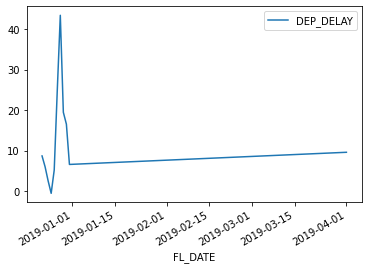

In [29]:
df_final_ATL.iloc[-100 : -80].plot()

In [52]:
### ERRORS MEASUREMENTS
expected = evaluation['Test_Set']
predicted = evaluation['Forecast']

## Mean Forecast Error
forecast_errors = [expected[i]-predicted[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
print('Mean Forecast Error - Bias: %f' % bias)

## Mean Absolute Error
mae = mean_absolute_error(expected, predicted)
print('Mean absolute error : %f' % mae)

## Mean Squared Error if = 0 Means NO ERROR
mse = mean_squared_error(expected, predicted)
print('Mean Squared Error: %f' % mse)

## Root Mean Squared Error if = 0 Means NO ERROR
rmse = sqrt(mse)
print('Root Mean Squared Error: %f' % rmse)

Mean Forecast Error - Bias: -0.219723
Mean absolute error : 5.190589
Mean Squared Error: 59.934896
Root Mean Squared Error: 7.741763


In [50]:
### ERRORS MEASUREMENTS - LAX
expected = evaluation_LAX['Test_Set_LAX']
predicted = evaluation_LAX['Forecast_Arima']

## Mean Forecast Error
forecast_errors = [expected[i]-predicted[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
print('Mean Forecast Error - Bias: %f' % bias)

## Mean Absolute Error
mae = mean_absolute_error(expected, predicted)
print('Mean absolute error : %f' % mae)

## Mean Squared Error if = 0 Means NO ERROR
mse = mean_squared_error(expected, predicted)
print('Mean Squared Error: %f' % mse)

## Root Mean Squared Error if = 0 Means NO ERROR
rmse = sqrt(mse)
print('Root Mean Squared Error: %f' % rmse)

Mean Forecast Error - Bias: -0.573488
Mean absolute error : 3.358779
Mean Squared Error: 19.875675
Root Mean Squared Error: 4.458214


In [53]:
### ERRORS MEASUREMENTS - JFK
expected = evaluation_JFK['Test_Set_JFK']
predicted = evaluation_JFK['Forecast_Arima']

## Mean Forecast Error
forecast_errors = [expected[i]-predicted[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
print('Mean Forecast Error - Bias: %f' % bias)

## Mean Absolute Error
mae = mean_absolute_error(expected, predicted)
print('Mean absolute error : %f' % mae)

## Mean Squared Error if = 0 Means NO ERROR
mse = mean_squared_error(expected, predicted)
print('Mean Squared Error: %f' % mse)

## Root Mean Squared Error if = 0 Means NO ERROR
rmse = sqrt(mse)
print('Root Mean Squared Error: %f' % rmse)

Mean Forecast Error - Bias: -0.566631
Mean absolute error : 10.209676
Mean Squared Error: 262.094801
Root Mean Squared Error: 16.189342


In [54]:
### ERRORS MEASUREMENTS - ATL
expected = evaluation_ATL['Test_Set_ATL']
predicted = evaluation_ATL['Forecast_Arima']

## Mean Forecast Error
forecast_errors = [expected[i]-predicted[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
print('Mean Forecast Error - Bias: %f' % bias)

## Mean Absolute Error
mae = mean_absolute_error(expected, predicted)
print('Mean absolute error : %f' % mae)

## Mean Squared Error if = 0 Means NO ERROR
mse = mean_squared_error(expected, predicted)
print('Mean Squared Error: %f' % mse)

## Root Mean Squared Error if = 0 Means NO ERROR
rmse = sqrt(mse)
print('Root Mean Squared Error: %f' % rmse)

Mean Forecast Error - Bias: 0.001980
Mean absolute error : 6.512958
Mean Squared Error: 135.499233
Root Mean Squared Error: 11.640414
